# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

[[ 1.10021448]
 [ 1.98547384]
 [ 1.10835316]
 [ 0.21124848]
 [-0.81288436]
 [-0.87764546]
 [ 1.50183732]
 [-0.49454282]
 [-1.82359693]
 [-0.62717494]]
[[21.76178927  8.22089927 12.69318729  6.56124507  7.09149805 16.89539924
   3.74122763  4.91628673 16.43309767 28.77529731]
 [ 4.05058515  8.29931218  7.52988077 20.02832821 14.45281289  1.69335979
  25.53388544 10.40845157  3.35731147 12.31923722]
 [ 6.83437086  0.5299296   6.90543097  5.54719813  0.69553623  5.3284302
   5.11123129  0.74342282  4.65168209 13.38331084]
 [ 9.61330144  4.20077743 14.321714    9.35912608  0.91839545 11.69605331
   3.54692679  3.89152872  8.48332487 14.78329237]
 [ 4.01975949  4.67115619  8.92227145 11.40152362  3.29446107  5.8539801
   3.50778253  2.32496576  2.65453352 10.90281771]
 [ 8.64300864  8.73018708  6.23057775  9.95377787  8.6201462   5.74090794
  18.48162995  9.55145909  6.44123187  0.91532397]
 [ 4.55062458  2.84646928  8.66190476  8.02847712  0.77991907  5.8158352
   5.58677665  2.74641558  3

## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** 
- Due to random initialization of W matrix to values close to 0, the scores obtained by X * W are also close to 0. Therefore, loss, which equals ** -log(e^score/sigma(e^score)), will equal (- log(1/10)) approximately.


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.487065 analytic: 0.487065, relative error: 5.924689e-08
numerical: -2.688258 analytic: -2.688258, relative error: 2.859042e-08
numerical: 3.110337 analytic: 3.110337, relative error: 9.003139e-09
numerical: 1.038941 analytic: 1.038941, relative error: 9.266118e-08
numerical: -0.450684 analytic: -0.450684, relative error: 9.086474e-08
numerical: 0.977054 analytic: 0.977054, relative error: 6.532699e-08
numerical: 1.939539 analytic: 1.939539, relative error: 1.355270e-08
numerical: 0.948610 analytic: 0.948610, relative error: 1.351426e-08
numerical: 0.405557 analytic: 0.405557, relative error: 3.435846e-08
numerical: 3.450803 analytic: 3.450803, relative error: 1.724847e-08
numerical: 0.232048 analytic: 0.232048, relative error: 1.659903e-07
numerical: 2.730227 analytic: 2.730227, relative error: 2.470217e-08
numerical: 1.110754 analytic: 1.110754, relative error: 1.922566e-08
numerical: -1.031673 analytic: -1.031673, relative error: 2.296778e-08
numerical: 0.422177 analytic

In [21]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.338040e+00 computed in 0.197086s
vectorized loss: 2.338040e+00 computed in 0.011178s
Loss difference: 0.000000
Gradient difference: 0.000000


In [22]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=learning_rate, reg=regularization_strength, num_iters=1500,verbose=True)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        accuracy_val = (np.mean(y_val == y_val_pred))
        if (accuracy_val > best_val):
            best_val = accuracy_val
            best_softmax = softmax
        results[(learning_rate, regularization_strength)] = (np.mean(y_train == y_train_pred), accuracy_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 387.834515
iteration 100 / 1500: loss 234.126599
iteration 200 / 1500: loss 142.019049
iteration 300 / 1500: loss 86.797847
iteration 400 / 1500: loss 53.326445
iteration 500 / 1500: loss 32.985216
iteration 600 / 1500: loss 20.763948
iteration 700 / 1500: loss 13.376887
iteration 800 / 1500: loss 8.874346
iteration 900 / 1500: loss 6.182312
iteration 1000 / 1500: loss 4.473465
iteration 1100 / 1500: loss 3.562695
iteration 1200 / 1500: loss 2.849217
iteration 1300 / 1500: loss 2.615955
iteration 1400 / 1500: loss 2.358167
iteration 0 / 1500: loss 778.829104
iteration 100 / 1500: loss 285.570230
iteration 200 / 1500: loss 105.876803
iteration 300 / 1500: loss 40.032775
iteration 400 / 1500: loss 15.982003
iteration 500 / 1500: loss 7.151632
iteration 600 / 1500: loss 3.952494
iteration 700 / 1500: loss 2.775888
iteration 800 / 1500: loss 2.342668
iteration 900 / 1500: loss 2.155052
iteration 1000 / 1500: loss 2.148929
iteration 1100 / 1500: loss 2.064791
iterat

In [23]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.360000


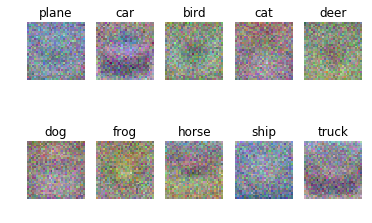

In [24]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])